<a href="https://colab.research.google.com/github/michhottinger/ds-unit-2-data/blob/master/Unit2DataEarthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://earthquake.usgs.gov/earthquakes/search/

for label understanding: https://earthquake.usgs.gov/data/comcat/

for reading: https://www.lanl.gov/discover/news-release-archive/2019/July/0718-machine-learning-earthquake-prediction.php

https://www.kaggle.com/c/LANL-Earthquake-Prediction

In [0]:
# Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install eli5==0.10.1
    !pip install pandas-profiling==2.3.0
    !pip install pdpbox==0.2.0
    !pip install plotly==4.1.1
    !pip install shap==0.30.0

     |████████████████████████████████| 92kB 2.7MB/s 
     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 614kB 9.3MB/s 
     |████████████████████████████████| 235kB 33.6MB/s 
     |████████████████████████████████| 307kB 32.5MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 215kB 25.5MB/s 
     |████████████████████████████████| 737kB 36.7MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=adea154661a35320274559e9ade0e324dc9a1bffd47b7621a471c775b29b1f21
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=f758e1a5b740d229c6eecff257cb29b55e88e211fe5f813f567b05ecd28770b4
  Stored in d

In [0]:
import pandas as pd

url = 'https://github.com/michhottinger/ds-unit-2-data/blob/master/Earthquakes.csv?raw=true'
df = pd.read_csv(url)
df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2019-11-04T01:02:47.980Z,35.754501,-121.425003,2.88,3.20,ml,64.0,197.0,0.13290,0.17,nc,nc73300510,2019-11-04T03:39:45.580Z,"25km WNW of San Simeon, CA",earthquake,0.55,1.66,0.131,17.0,automatic,nc,nc
1,2019-11-03T20:34:57.020Z,38.775333,-122.768166,2.18,4.15,mw,53.0,68.0,0.03888,0.13,nc,nc73300395,2019-11-04T04:10:26.429Z,"1km WSW of The Geysers, CA",earthquake,0.16,0.67,NaN,4.0,reviewed,nc,nc
2,2019-11-03T15:45:55.570Z,35.632500,-117.433334,3.22,3.37,ml,67.0,29.0,0.05158,0.21,ci,ci38930143,2019-11-04T03:53:16.878Z,"15km S of Searles Valley, CA",earthquake,0.21,0.75,0.254,21.0,automatic,ci,ci
3,2019-11-03T15:18:33.070Z,35.619999,-117.435997,2.92,2.84,ml,56.0,28.0,0.11130,0.16,ci,ci38930111,2019-11-03T15:29:33.460Z,"17km S of Searles Valley, CA",earthquake,0.18,0.86,0.237,24.0,automatic,ci,ci
4,2019-11-03T14:42:24.860Z,37.423832,-118.550835,13.16,2.85,md,25.0,72.0,0.07124,0.05,nc,nc73300255,2019-11-03T15:38:03.642Z,"4km ENE of Round Valley, CA",earthquake,0.45,1.26,0.220,30.0,automatic,nc,nc


In [0]:
df.isnull().sum()
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,19036.000000,19036.000000,19036.000000,19036.000000,18657.000000,19012.000000,18658.000000,18952.000000,16889.000000,18847.000000,17693.000000,18796.000000
mean,35.992152,-118.590476,8.181421,2.952754,39.714370,129.348523,0.239928,0.214297,1.275572,6.171684,0.185261,63.215205
std,3.416570,3.256494,6.385612,0.453419,35.735842,90.940478,0.369496,0.430374,4.452261,11.429472,0.084740,67.851433
min,29.100000,-127.264800,-2.615000,2.500000,0.000000,7.000000,0.000785,0.000000,0.014000,0.000000,0.000000,0.000000
25%,32.651625,-120.985167,3.569250,2.630000,15.000000,50.000000,0.049085,0.120000,0.180000,0.410000,0.141000,13.000000
50%,35.791584,-117.677167,7.350000,2.810000,29.000000,94.000000,0.109650,0.170000,0.330000,0.790000,0.170000,38.000000
75%,38.740292,-115.750667,10.135250,3.130000,54.000000,219.000000,0.262200,0.230000,1.140000,3.340000,0.212000,92.000000
max,46.556000,-114.612000,104.300000,7.200000,760.000000,357.000000,5.654000,40.860000,99.000000,374.500000,1.620000,438.000000


In [0]:
df.shape

(19036, 22)

In [0]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
import plotly.express as px

fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', color='mag', opacity=0.5)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [0]:
df.mag = df['mag'].astype(int)
df.mag.describe()
df.mag.nunique()
df.mag.value_counts()

2    12700
3     5597
4      674
5       57
6        6
7        2
Name: mag, dtype: int64

In [0]:
#check for missing NaN values
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                 379
gap                  24
dmin                378
rms                  84
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    2147
depthError          189
magError           1343
magNst              240
status                0
locationSource        0
magSource             0
dtype: int64

In [0]:
#fill NaNs with mean
df = df.fillna(df.mean())

#check to make sure it worked
df.isnull().sum()

time               0
latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                0
gap                0
dmin               0
rms                0
net                0
id                 0
updated            0
place              0
type               0
horizontalError    0
depthError         0
magError           0
magNst             0
status             0
locationSource     0
magSource          0
dtype: int64

In [0]:
#create bins for mag earthquake #data can be broken into two categories of earthquake based on mag and used as a target to predict size of quake
dfc = df
bins = [0, 5, 7] # (exlusive, inclusive]
labels = ['shake 0-5', 'terrifying 5.1-7']
dfc['binned'] = pd.cut(dfc['mag'], bins=bins, labels=labels)
dfc.binned.value_counts()

shake 0-5           19028
terrifying 5.1-7        8
Name: binned, dtype: int64

In [0]:
target = 'binned'
dfc = dfc.drop(columns='mag')

In [0]:
#bring back the more common, smaller quakes for the machine learning model
#create bins for mag earthquake #data can be broken into two categories of earthquake based on mag and used as a target to predict size of quake
dfq = df
bins = [0, 2, 4, 7] # (exlusive, inclusive]
labels = ['murmer 1-2', 'shake 3-4', 'terrifying 5-7']
dfq['binned'] = pd.cut(dfq['mag'], bins=bins, labels=labels)
dfq.binned.value_counts()

murmer 1-2        12700
shake 3-4          6271
terrifying 5-7       65
Name: binned, dtype: int64

In [0]:
#image is with dfc with 5.1 and greater in red
fig = px.scatter_mapbox(dfc, lat='latitude', lon='longitude', color='binned', opacity=1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [0]:
# Split train into train & val and test
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train1, val1 = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['mag'], random_state=42)

print('val1:', val1.shape)

traint, test1 = train_test_split(train1, train_size=0.80, test_size=0.20,
                              stratify=train1['mag'], random_state=42)
print('traint:', traint.shape, 'test1:', test1.shape)

val1: (3808, 23)
traint: (12182, 23) test1: (3046, 23)


Get some baselines to beat!!!

In [0]:
df.mag.value_counts(normalize=True)

2    0.667157
3    0.294022
4    0.035407
5    0.002994
6    0.000315
7    0.000105
Name: mag, dtype: float64

Mag 7 earthquakes are so rare. They only occur .01 percent of the time

In [0]:
df.binned.value_counts(normalize=True)

murmer 1-2        0.667157
shake 3-4         0.329428
terrifying 5-7    0.003415
Name: binned, dtype: float64

In [0]:
def clean(X):
  X = X.copy()
  X['time'] = pd.to_datetime(X['time'], infer_datetime_format=True)
  X['year'] = X['time'].dt.year
  X['month'] = X['time'].dt.month
  X = X.drop(columns='time')
  return X

test = clean(test1)
val = clean(val1)
train = clean(traint)


In [0]:
# Assign to X, y

target = 'mag'
features = train.columns.drop([target, 'binned', 'magNst', 'id', 'locationSource', 'magType', 'status', 'updated', 'type', 'net', 'place', 'magSource'])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


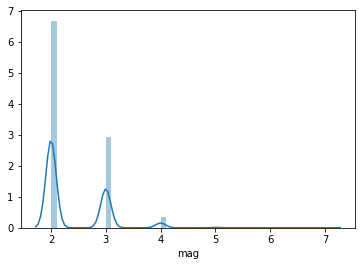

In [0]:
# The target has some right skew
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

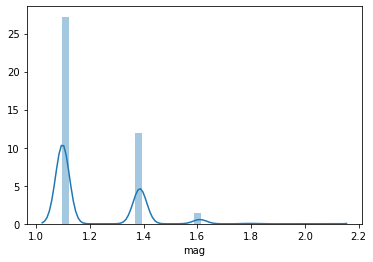

In [0]:
#very little change with the log transformed graph
y = y_train
y_log = np.log1p(y)
sns.distplot(y_log);

In [0]:
#fit a logistic regression model
# Fit model
!pip install category_encoders
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning:

The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Validation Accuracy 0.6714810924369747


Above a simple logistic regression model will beat baseline.

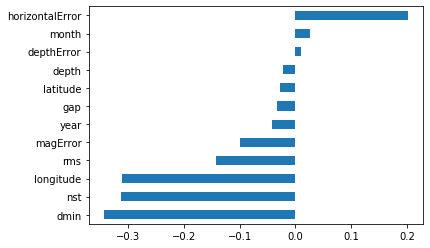

In [0]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();
#this indicated that I MUST drop magType since it is directly a 1 coef (its now dropped so you can't see it here)

In [0]:
#random forest model

!pip install category_encoders
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))


Validation Accuracy 0.739233193277311


In [0]:
#randomized search cv for random forest model to get the best parameters

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.6s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 0.3758702958922821


In [0]:
#use the best params
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=156, random_state=42, max_features=0.9507, max_depth=20, n_jobs=-1)
)

# Fit on train, score on val

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7397584033613446


In [59]:
#run the model on test to see how it does
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7465528562048588


Test performed slightly better than the validation set.

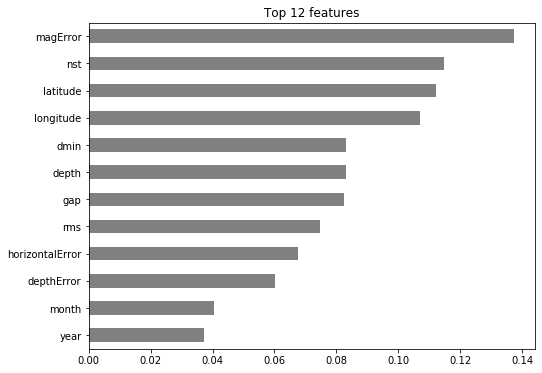

In [0]:
# Get feature importances from random forest
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 12
plt.figure(figsize=(8,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


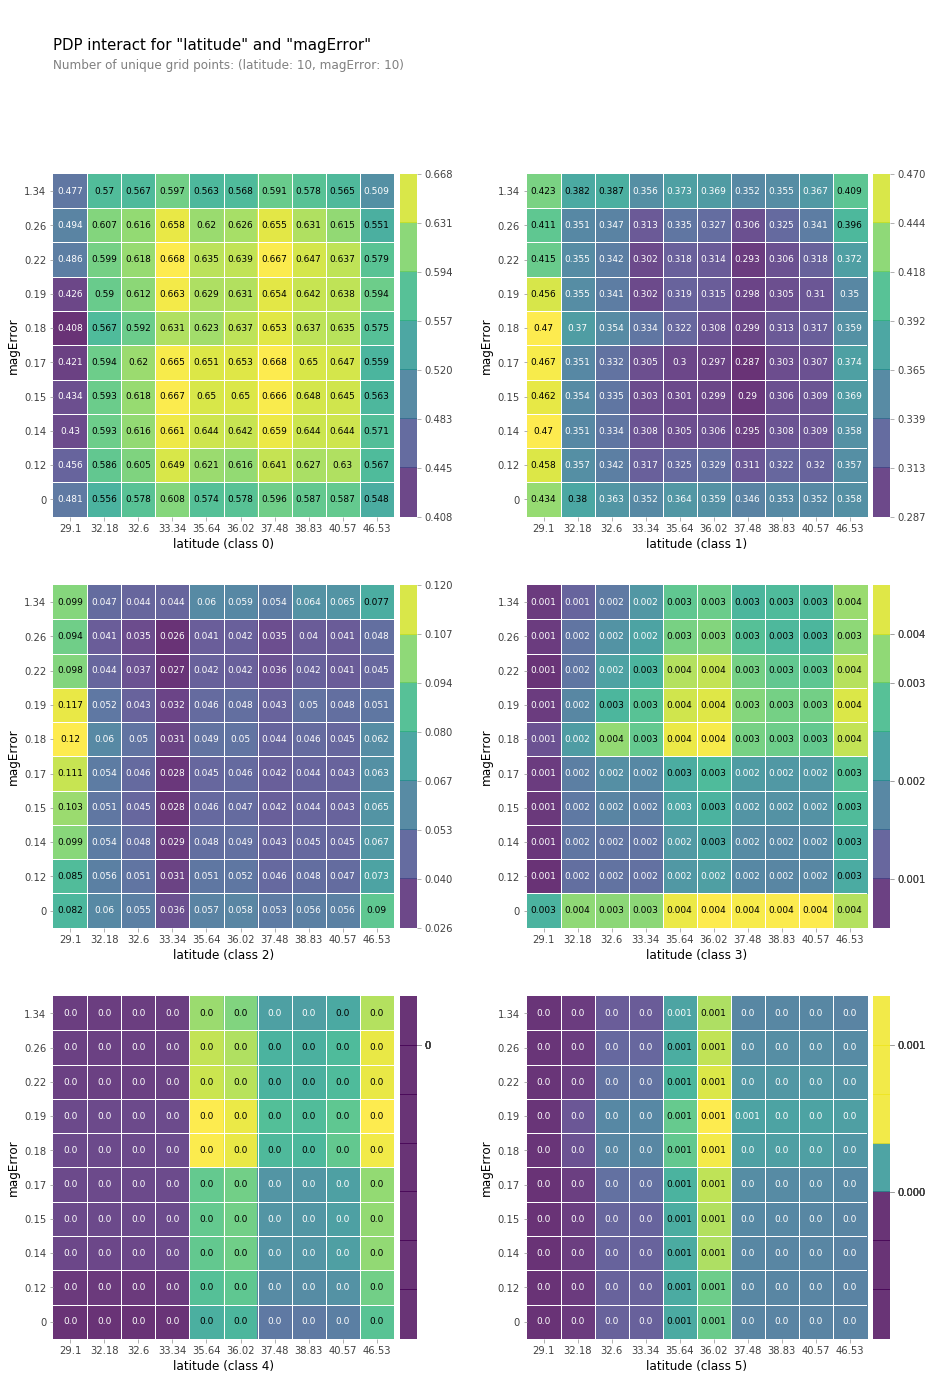

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['latitude', 'magError']


interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

The 0-5 classes indicate the different magnitudes of 2-7.

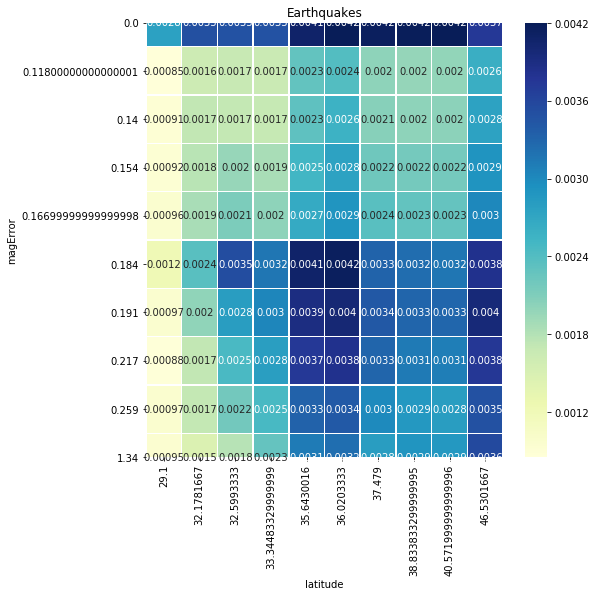

In [0]:

pdp = interaction[3].pdp.pivot_table(
    values='preds', 
    columns=interaction[3].pdp.columns[0], 
    index=interaction[3].pdp.columns[1]
)
#[::-1] # Slice notation to reverse index order so y axis is ascending

plt.figure(figsize=(8,8))
sns.heatmap(pdp, linewidths=.5, annot=True, cmap="YlGnBu") #fmt='.2f'
plt.title('Earthquakes');

In [0]:
!pip install plotly==4.1.1

In [0]:
#Use above pdp plot to graph 3d surface
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)
layout = go.Layout(
    scene=dict(
        xaxis=dict(title=interaction[3].pdp.columns[0]), 
        yaxis=dict(title=interaction[3].pdp.columns[1]), 
        zaxis=dict(title=target)
    )
)
fig = go.Figure(surface, layout)
fig.show()

In [0]:
#XGBoostClassifier model
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)



eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

gb = XGBClassifier(
    n_estimators=100, # <= 1000 trees, depends on early stopping
    max_depth=10,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.75, # try higher learning rate
    n_jobs=-1
)


gb.fit(X_train_transformed, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.198736	validation_1-merror:0.27626
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.171072	validation_1-merror:0.279674
[2]	validation_0-merror:0.157035	validation_1-merror:0.2823
[3]	validation_0-merror:0.137088	validation_1-merror:0.282038
[4]	validation_0-merror:0.123215	validation_1-merror:0.279412
[5]	validation_0-merror:0.10614	validation_1-merror:0.282038
[6]	validation_0-merror:0.090133	validation_1-merror:0.280462
[7]	validation_0-merror:0.082663	validation_1-merror:0.281775
[8]	validation_0-merror:0.072238	validation_1-merror:0.283613
[9]	validation_0-merror:0.066327	validation_1-merror:0.280987
[10]	validation_0-merror:0.061813	validation_1-merror:0.2802
[11]	validation_0-merror:0.046134	validation_1-merror:0.282038
[12]	validation_0-merror:0.039895	validation_1-merror:0.28125
[13]	validation_0-merror:0.033164	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.75, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#changed n_estimaters from 1000 down to 100 bc the below graphs indicate the gains are low and the time saved is high in running this model.
from sklearn.metrics import r2_score
y_pred = gb.predict(X_val_transformed)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))
print('Accuracy:', accuracy_score(y_val, y_pred))

Gradient Boosting R^2 0.0711548124011856
Accuracy: 0.7345063025210085


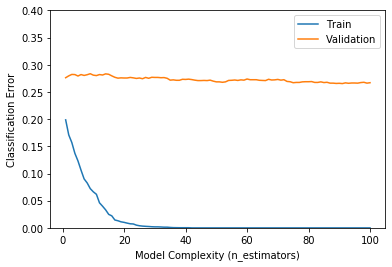

In [0]:
#graph of above model gb
results = gb.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0, 0.4)) # Zoom in
plt.legend();

In [0]:
#transform dataframe to perform roc auc score--make into a binary classification

dfbi = df
dfbi['large_mag'] = dfbi['mag'] >=4.0
df.large_mag.value_counts(normalize=True)

False    0.961179
True     0.038821
Name: large_mag, dtype: float64

In [0]:
dfbi.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,binned,large_mag
0,2019-11-04T01:02:47.980Z,35.754501,-121.425003,2.88,3,ml,64.0,197.0,0.13290,0.17,nc,nc73300510,2019-11-04T03:39:45.580Z,"25km WNW of San Simeon, CA",earthquake,0.55,1.66,0.131000,17.0,automatic,nc,nc,shake 3-4,False
1,2019-11-03T20:34:57.020Z,38.775333,-122.768166,2.18,4,mw,53.0,68.0,0.03888,0.13,nc,nc73300395,2019-11-04T04:10:26.429Z,"1km WSW of The Geysers, CA",earthquake,0.16,0.67,0.185261,4.0,reviewed,nc,nc,shake 3-4,True
2,2019-11-03T15:45:55.570Z,35.632500,-117.433334,3.22,3,ml,67.0,29.0,0.05158,0.21,ci,ci38930143,2019-11-04T03:53:16.878Z,"15km S of Searles Valley, CA",earthquake,0.21,0.75,0.254000,21.0,automatic,ci,ci,shake 3-4,False
3,2019-11-03T15:18:33.070Z,35.619999,-117.435997,2.92,2,ml,56.0,28.0,0.11130,0.16,ci,ci38930111,2019-11-03T15:29:33.460Z,"17km S of Searles Valley, CA",earthquake,0.18,0.86,0.237000,24.0,automatic,ci,ci,murmer 1-2,False
4,2019-11-03T14:42:24.860Z,37.423832,-118.550835,13.16,2,md,25.0,72.0,0.07124,0.05,nc,nc73300255,2019-11-03T15:38:03.642Z,"4km ENE of Round Valley, CA",earthquake,0.45,1.26,0.220000,30.0,automatic,nc,nc,murmer 1-2,False


This is showing how incredibly rare larger earthquakes have been historically compared to many small earth quakes.

In [0]:
# Split train into train & val
import numpy as np
from sklearn.model_selection import train_test_split

train3, val2 = train_test_split(dfbi, train_size=0.80, test_size=0.20, 
                              stratify=dfbi['large_mag'], random_state=42)

print('val2:', val2.shape)

train2, test2 = train_test_split(train3, train_size=0.80, test_size=0.20,
                              stratify=train3['large_mag'], random_state=42)
print('train2:', train2.shape, 'test2:', test2.shape)

val2: (3808, 24)
train2: (12182, 24) test2: (3046, 24)


In [0]:
def clean(X):
  X = X.copy()
  X['time'] = pd.to_datetime(X['time'], infer_datetime_format=True)
  X['year'] = X['time'].dt.year
  X['month'] = X['time'].dt.month
  X = X.drop(columns='time')
  return X

testb = clean(test2)
valb = clean(val2)
trainb = clean(train2)

# Assign to X, y

target = 'large_mag'
features = trainb.columns.drop([target, 'binned', 'mag', 'magNst', 'id', 'locationSource', 'magType', 'status', 'updated', 'type', 'net', 'place', 'magSource', 'horizontalError', 'magError'])

X_trainb = trainb[features]
y_trainb = trainb[target]

X_valb = valb[features]
y_valb = valb[target]

X_testb = testb[features]
y_testb = testb[target]

#false = 0 and the quake is small or less than 4.0 true = 1 and the quake is large or more than 4.0


In [0]:
#get baselines
from sklearn.metrics import mean_absolute_error
# Just for demonstration
#majority_class = y_train.mode()[0]
#y_pred = [majority_class] * len(y_train)


y = dfbi[target]
y_pred = [y.mean()] * len(y)
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))

Mean Absolute Error: 0.07462819366461997


In [0]:
#run XGBoostClassifier with auc score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier


processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_trainb_processed = processor.fit_transform(X_trainb)
X_valb_processed = processor.transform(X_valb)

eval_set = [(X_trainb_processed, y_trainb), 
            (X_valb_processed, y_valb)]

modelb = XGBClassifier(n_estimators=1000, n_jobs=-1)
modelb.fit(X_trainb_processed, y_trainb, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.580163	validation_1-auc:0.562031
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.646925	validation_1-auc:0.625505
[2]	validation_0-auc:0.6486	validation_1-auc:0.625377
[3]	validation_0-auc:0.648595	validation_1-auc:0.625386
[4]	validation_0-auc:0.6654	validation_1-auc:0.632387
[5]	validation_0-auc:0.664869	validation_1-auc:0.632535
[6]	validation_0-auc:0.66585	validation_1-auc:0.633328
[7]	validation_0-auc:0.698373	validation_1-auc:0.677094
[8]	validation_0-auc:0.702585	validation_1-auc:0.68525
[9]	validation_0-auc:0.704869	validation_1-auc:0.686834
[10]	validation_0-auc:0.705098	validation_1-auc:0.687794
[11]	validation_0-auc:0.704101	validation_1-auc:0.68562
[12]	validation_0-auc:0.704611	validation_1-auc:0.694081
[13]	validation_0-auc:0.705454	validation_1-auc:0.691668
[14]	validation_0-auc:0.705269	validation_1-auc:0.689658
[15]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
from sklearn.metrics import roc_auc_score
X_testb_processed = processor.transform(X_testb)
class_index = 1
y_pred_proba = modelb.predict_proba(X_testb_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_testb, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.723933731592109


In [0]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_testb)
class_index = 0
y_pred_proba = modelb.predict_proba(X_testb_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_testb, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 0:
0.2760662684078911


In [0]:
!pip install eli5

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    modelb, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_valb_processed, y_valb)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [0]:
feature_names = X_valb.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

gap           0.005462
nst           0.002941
rms           0.002101
longitude     0.001366
dmin          0.000578
month         0.000000
year          0.000000
depthError    0.000000
depth         0.000000
latitude     -0.000158
dtype: float64

In [0]:
feature_names = X_valb.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0055 ± 0.0029,gap
0.0029 ± 0.0025,nst
0.0021 ± 0.0006,rms
0.0014 ± 0.0012,longitude
0.0006 ± 0.0006,dmin
0 ± 0.0000,month
0 ± 0.0000,year
0 ± 0.0000,depthError
0 ± 0.0000,depth
-0.0002 ± 0.0003,latitude


In [0]:
#XGBoost Regressor model

from sklearn.metrics import r2_score
from xgboost import XGBRegressor
gbr = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.31988749102816716


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


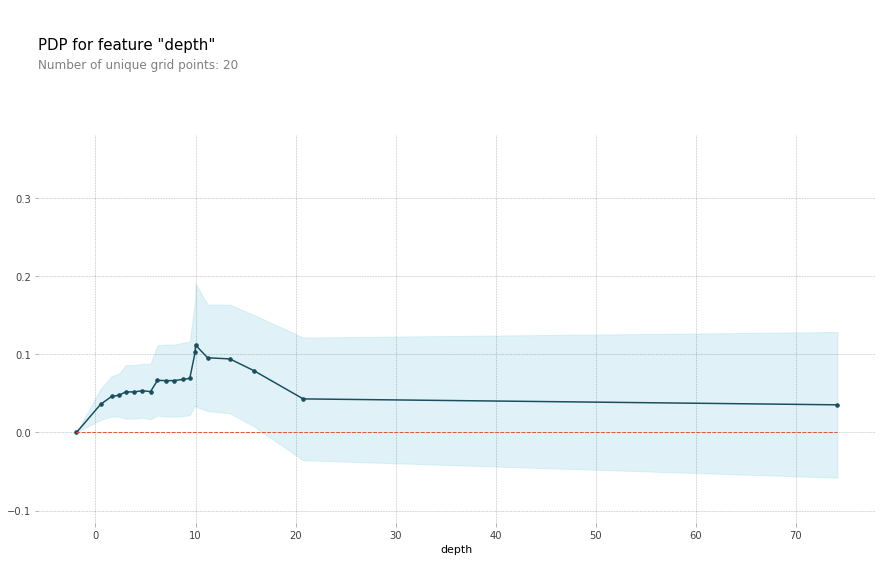

In [0]:
#only works on gbregressor, not classifier
!pip install pdpbox==0.2.0
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

feature = 'depth'

isolated = pdp_isolate(
    model=gbr,
    num_grid_points=20, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

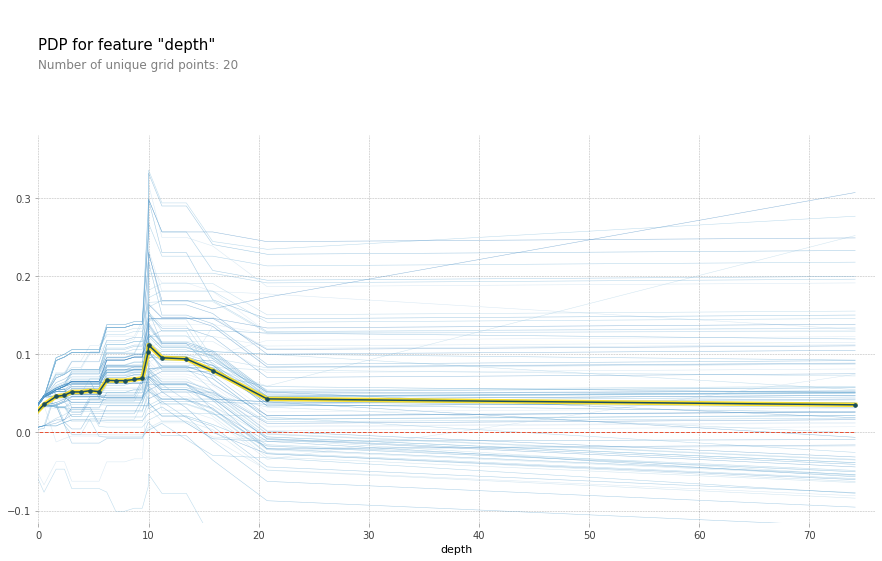

In [0]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100) # Confusing parameter name
plt.xlim(0,76);

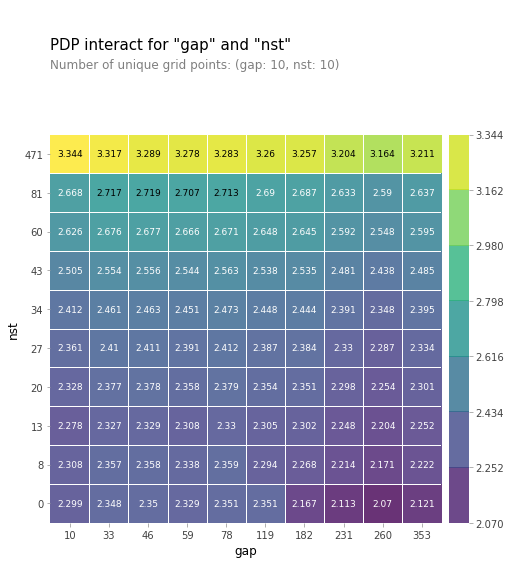

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['gap', 'nst']

interaction = pdp_interact(
    model=gbr,
    dataset=X_val,
    n_jobs=1, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

Text(0.5, 1, 'Partial Dependence of gap and nst on magnitude')

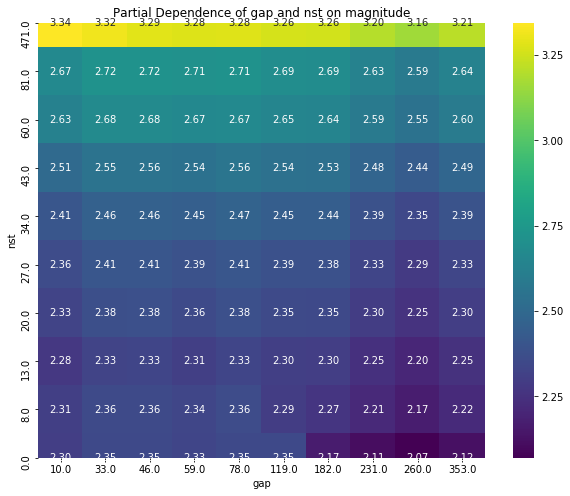

In [0]:
features = ['gap', 'nst']

pdp = interaction.pdp.pivot_table(
      values='preds', 
      columns=features[0], 
      index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of gap and nst on magnitude')

In [0]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)

layout = go.Layout(
      scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

In [0]:
#find a row to use for data in shap plot
row = X_testb.iloc[[2114]]
row

,latitude,longitude,depth,nst,gap,dmin,rms,depthError,year,month
16538,32.656667,-115.79,9.135,34.0,151.0,0.02419,0.14,0.27,2010,4


In [0]:
!pip install Shap

In [0]:
import shap

explainer = shap.TreeExplainer(modelb)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [0]:
# Assign to X, y
features = ['latitude', 'longitude', 'rms', 'nst', 'depthError', 'dmin', 'gap']
target = 'mag'
X_train_fix = train[features]
y_train_fix = train[target]
X_test_fix = test[features]
y_test_fix = test[target]

In [0]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train_fix, y_train_fix);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.7s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 0.4080359299163952


In [0]:
def predict(latitude, longitute, rms, nst, depthError, dmin, gap):
    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[latitude, longitute, rms, nst, depthError, dmin, gap]], 
        columns=['latitude', 'longitude', 'rms', 'nst', 'depthError', 'dmin', 'gap']
    )

    # Get the model's prediction
    pred = model.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'{pred:,.0f}% Estimated Earthquake \n\n'
    result += f'Starting from baseline of {explainer.expected_value:,.0f}% \n'
    result += shaps.to_string()
    print(result)

    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict(25, -114, 0.10, 35, 0.25, 0.028, 152)

3% Estimated Earthquake 

Starting from baseline of 2% 
(latitude, 25.0)       0.318978
(longitude, -114.0)    0.236708
(rms, 0.1)            -0.069143
(nst, 35.0)            0.069092
(depthError, 0.25)     0.008508
(dmin, 0.028)         -0.017647
(gap, 152.0)           0.020345


Prediction titles: latitude, longitute, rms, nst, depthError, dmin, gap